# Dynamic Programming Introduction.

---

I highly recommend to visit David Silver Lectures on Planning by Dynamic Programming: https://www.youtube.com/watch?v=Nd1-UUMVfz4

**Dynamic Programming** is a very general solution method for problems which have two properties:
1. Optimal substructure, i.e, Principle of optimality applies and optimal solution can be decomposed into subproblems. 
2. Overlapping subproblems, i.e, subproblems recur many times and solutions can be cached and reused. 
Fortunately, Markov decision processes satisfy both properties: Bellman equation gives recursive decomposition and value function stores a reuses solutions.

The esence of dynamic programming is based on the fact that we have full knowledge of the MDP, which we will use for planning. But, what does full knowledge means? It means we can completely characterize all the states, actions, transition probabilities and reward function of the stochastic process. This is an extremely weird case when developing IA in practice!

In [13]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [14]:
class Graphics():
    
    def __init__(self):
        print("Graphics module ready!")
        
    def render(self, x, y, environment, plot_values = True):
            
        fig1 = plt.figure(figsize=(4, 4))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

        # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))
        
        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.4), 0.2, 0.2, facecolor = "#33A4FF"))
        
        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot player.
        plt.scatter(x, y, s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        if plot_values:
            for i in range(0, len(environment.value_state_table)):
                for j in range(0, len(environment.value_state_table[0])):
                    plt.text(environment.grid_pos[i] - 0.08, environment.grid_pos[j] - 0.03, 
                             round(environment.value_state_table[i][j], 2), fontsize=16)
                
        # Plot grid.
        plt.axis("off")
        plt.show()  

In [15]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1]]
        self.rewards = [[self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, 10, self.rw]]
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]
        self.value_state_table = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 1, 0]]
        
    def getStateValue(self, position):
        return self.value_state_table[position[0]][position[1]]
    
    def reset(self):
        self.value_state_table = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 1, -1]]

Graphics module ready!


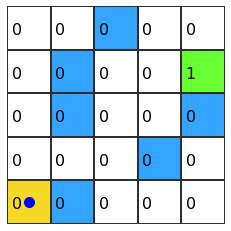

In [16]:
environment = GridEnvironment()
graph = Graphics()
graph.render(0.1, 0.1, environment)

In [17]:
class valueBasedAgent():
    
    def __init__(self, environment, policy):
        self.pos = [0,0]
        self.total_reward = 0
        self.environment = environment
        self.discount_factor = 0.5
        self.actions = ["up", "down", "left", "right"]
        
        # Start with a random policy. 0.25 chance of moving to any direction.
        self.policy = policy   
        
    # Select action according to policy.
    """
    def selectAction(self, state):
        
        if(self.policy[state[0]][state[1]] == "r"):
            action = self.actions[random.randint(0, len(self.available_actions) - 1)] # Agent initial policy.
        else: 
            action = self.policy[state[0]][state[1]]
        return action
    """
            
    def forwardState(self, pos, action):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(self.environment.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]

        elif(action == "down" and pos[1] > 0):
            if(self.environment.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]
        elif(action == "left" and pos[0] > 0):
            if(self.environment.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]

        elif(action == "right" and pos[0] < 4):
            if(self.environment.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position
        
        
    def valueFunction(self):
            
        # Initialize variable.
        new_state_value = 0
    
        # Random movement!
        if self.policy[self.pos[0]][self.pos[1]] == "r":
            for action in self.actions:        
                forward_state = self.forwardState(self.pos, action)
                expected_return = (self.environment.rewards[forward_state[0]][forward_state[1]] 
                                    + self.discount_factor * self.environment.value_state_table[forward_state[0]][forward_state[1]])
                new_state_value += expected_return * 0.25
            return new_state_value
        
        # Not random movement!
        else: 
            action = self.policy[self.pos[0]][self.pos[1]]
            forward_state = self.forwardState(self.pos, action)
            expected_return = (self.environment.rewards[forward_state[0]][forward_state[1]] 
                                    + self.discount_factor * self.environment.value_state_table[forward_state[0]][forward_state[1]])
            new_state_value += expected_return
            return new_state_value
        
    def getPosition(self):
        return self.pos
    
    def getReward(self):
        return self.total_reward
    
    def setPosition(self, x, y):
        self.pos = [x, y]
        
    def updateValueStateTable(self):
        new_state_value = self.valueFunction()
        self.environment.value_state_table[self.pos[0]][self.pos[1]] = new_state_value
        
    def selectBestAction(self):
        
        go_up = self.forwardState(self.pos, "up")
        go_down = self.forwardState(self.pos, "down")
        go_left = self.forwardState(self.pos, "left")
        go_right = self.forwardState(self.pos, "right")
        
        up_value = self.environment.value_state_table[go_up[0]][go_up[1]]
        down_value =  self.environment.value_state_table[go_down[0]][go_down[1]]
        left_value =  self.environment.value_state_table[go_left[0]][go_left[1]]
        right_value =  self.environment.value_state_table[go_right[0]][go_right[1]]
        values = [up_value, down_value, left_value, right_value]
        
        best_action = self.actions[values.index(max(values))] 
        return best_action       
            
    def move(self):
    
        # Select action according to policy.
        action = self.policy[self.pos[0]][self.pos[1]]
        print("Action taken", action)

        # Move to new position according to action taken.
        self.pos = self.forwardState(self.pos, action)
        print("New Position: ", self.pos)

In [18]:
class PolicyEvaluation(Graphics):
    
    def __init__(self, environment, agent, iterations = 3):
        
        self.environment = environment       
        self.agent = agent                     
        print("GridWorld Initialize!")
        self.iterations = iterations
    
    def evaluate(self, plot_grid = True):
        self.DP_policy_evaluation(self.iterations, plot_grid)
        
    def DP_policy_evaluation(self, iterations, plot_grid):
        
        for k in range(0, iterations):
        
            for i in range(0, len(self.environment.value_state_table)):
                for j in range(0, len(self.environment.value_state_table[0])):

                    if self.environment.walls_and_paths[i][j] == 1 and self.canChangeStateValue(i, j):

                        # Set agent position.
                        self.agent.setPosition(i, j)
                        self.agent.updateValueStateTable()

                        # Method of the super class.
                        if(plot_grid):
                            
                            # Render game.
                            pos = self.agent.getPosition()
                            grid_coords = self.environment.grid_pos
                            
                            self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, True)
                            time.sleep(0.01)
                            clear_output(wait = True)
    

    def canChangeStateValue(self, x, y):
        cant_modify = bool((x == 4 and y == 3)) # or (x == 4 and y == 4))
        
        grid = self.environment.walls_and_paths
        coords = list()
        
        # Get walls.
        for i in range(0, len(grid)):
            for j in range(0, len(grid[0])):
                if grid[i][j] == 0:
                    coords.append([i, j])
        for c in coords: 
            if c == [x, y]:
                cant_modify = True
                break
                
        return not cant_modify
    
    def updatePolicy(self):
        
         for i in range(0, len(self.environment.value_state_table)):
                for j in range(0, len(self.environment.value_state_table[0])):
                    if self.environment.walls_and_paths[i][j] == 1:
                        
                        # Set agent position.
                        self.agent.setPosition(i, j)
                        best_action = self.agent.selectBestAction()
                        self.agent.policy[i][j] = best_action

In [19]:
class Game(Graphics):
    
    def __init__(self, environment, agent):
        
        self.environment = environment       
        self.agent = agent             
        print("GridWorld Initialize!")
                
    def update(self, secs):
        
        pos = self.agent.getPosition()
        grid_coords = self.environment.grid_pos
        self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
        time.sleep(1)
        clear_output(wait = True)
        
        while not ((self.agent.pos[0] == 4 and self.agent.pos[1] == 4) or (self.agent.pos[0] == 4 and self.agent.pos[1] == 3)):
            
            self.agent.move()
            pos = self.agent.getPosition()
            self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
            
            time.sleep(secs)
            clear_output(wait = True)
            
        self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
        print("Yuhuu, we won the game!")
        clear_output(wait = True)

### 1. Policy Evaluation (Prediction or Planning) for DP.

In [20]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)

In [21]:
policy

[['r', 'r', 'r', 'r', 'r'],
 ['r', 'r', 'r', 'r', 'r'],
 ['r', 'r', 'r', 'r', 'r'],
 ['r', 'r', 'r', 'r', 'r'],
 ['r', 'r', 'r', 'r', 'r']]

In [22]:
# Initialize environment and agent.
environment = GridEnvironment()
agent = valueBasedAgent(environment, policy)

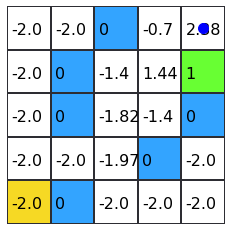

In [23]:
# Initialize policy evaluation class.
policy_evaluation = PolicyEvaluation(environment, agent, iterations = 10)
policy_evaluation.evaluate()
policy_evaluation.updatePolicy()

In [24]:
agent.policy

[['up', 'right', 'down', 'down', 'down'],
 ['r', 'right', 'r', 'r', 'left'],
 ['up', 'up', 'up', 'right', 'r'],
 ['left', 'r', 'up', 'right', 'right'],
 ['left', 'down', 'r', 'up', 'up']]

#### Win the Game with the previous policity evaluation results.

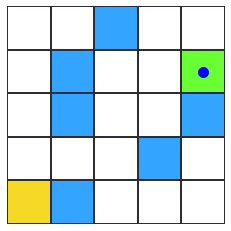

Yuhuu, we won the game!


In [27]:
positions = [[1, 4], [4, 1], [0, 0]]

for p in positions: 
    agent.pos = p
    game = Game(environment, agent)
    game.update(0.1)

Great! We made it! We have developed our first artificial intelligence. As you can see, we took a random policy and evaluate it through our policity evaluation algorithm, then, we encourage our agent to take the best action for each state, which lead us to an amazing result.

Something that surprised me the very first time I learnt about **Dynamic Programming**, was the fact that even though we chose a random policy, it led us to a solution of the grid world problem. According to the this, how our solution could change if we would have choosen a more reasonable policy? This is the question that we are going to try to answer in the following section, through **Policity Iteration** and **Value Iteration**.

### 2. Policy Iteration (Control). Improving our Policy.

In [28]:
# New Policy after the Game.
agent.policy

[['up', 'right', 'down', 'down', 'down'],
 ['r', 'right', 'r', 'r', 'left'],
 ['up', 'up', 'up', 'right', 'r'],
 ['left', 'r', 'up', 'right', 'right'],
 ['left', 'down', 'r', 'up', 'up']]

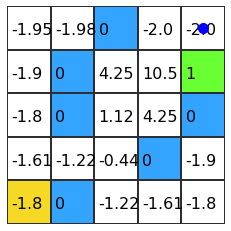

In [23]:
# Reset value function.
environment.reset()

# Evaluate new policy.
policy_evaluation = PolicyEvaluation(environment, agent, iterations = 10)
policy_evaluation.evaluate(plot_grid = False)
policy_evaluation.updatePolicy()

In [24]:
policy_evaluation.updatePolicy()

In [25]:
agent.policy

[['up', 'right', 'down', 'down', 'down'],
 ['r', 'right', 'r', 'r', 'left'],
 ['up', 'up', 'up', 'right', 'r'],
 ['left', 'r', 'up', 'down', 'down'],
 ['left', 'down', 'r', 'left', 'down']]